<a href="https://colab.research.google.com/github/peterjsadowski/keras_tutorial/blob/master/3_keras_mnist_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keras Tutorial for Generative Adversarial Nets
This tutorial introduces Generative Adversarial Networks on MNIST.



In [1]:
import numpy as np
import os
import numpy.random
import matplotlib.pyplot as plt

from collections import defaultdict
from tqdm import tqdm
from IPython import display

import keras
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Activation, Input, Convolution2D, Flatten, BatchNormalization
from keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras.optimizers import SGD,Adam


## Define data.

In [2]:
# Load data.
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
print("Original X shape", X_train.shape)
print("Original Y shape", Y_train.shape)

# Reshape data.
X_train = X_train.reshape(60000, 784)
X_test  = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')
X_train /= 255 # Original data is uint8 (0-255). Scale it to range [0,1].
X_test  /= 255
print("Training X matrix shape", X_train.shape)
print("Testing X matrix shape", X_test.shape)

# Represent the targets as one-hot vectors: e.g. 2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0].
nb_classes = 10
Y_train = to_categorical(Y_train, nb_classes)
Y_test  = to_categorical(Y_test, nb_classes)
print("Training Y matrix shape", Y_train.shape)
print("Testing Y matrix shape", Y_test.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Original X shape (60000, 28, 28)
Original Y shape (60000,)
Training X matrix shape (60000, 784)
Testing X matrix shape (10000, 784)
Training Y matrix shape (60000, 10)
Testing Y matrix shape (10000, 10)


# Define Keras Model


In [26]:
# Model
def define_generator(ndense=1, nhid=100, learning_rate=1e-3, act='relu', mom=0.9, dropout=0.0, input_shape=20):
    # Define 'generator' that predicts sig vs bg from features.
    input_shape = input_shape # Number of inputs to generator (random numbers)
    output_shape= 784
    ndense      = 2
    nhid        = 100
    act         = 'relu'
    input       = Input(shape=(input_shape,), name='input')
    x           = input
    for i in range(ndense):
        x = Dense(units=nhid, activation=act)(x)
        x = BatchNormalization()(x)
    output    = Dense(units=output_shape, activation='sigmoid', name='output')(x)
    generator = Model(input, output)
    opt       = Adam(learning_rate=learning_rate, beta_1=mom)
    #generator.compile(loss='binary_crossentropy', optimizer=opt)
    return generator

def define_discriminator(ndense=1, nhid=100, act='relu', learning_rate=1e-3, mom=0.9, decay=0.0, dropout=0.0):
    # Define 'discriminator' that predicts whether input is generated vs. real.
    input_shape = 784
    output_shape= 1
    ndense      = ndense
    nhid        = nhid
    act         = act
    input       = Input(shape=(input_shape,))
    x           = input
    for i in range(ndense):
        x = Dense(units=nhid, activation=act)(x)
    output = Dense(units=output_shape, activation='sigmoid')(x)
    discriminator = Model(input, output)
    #opt       = Adam(lr=lr, beta_1=mom)
    opt = SGD(learning_rate=learning_rate,momentum=mom,decay=decay)
    discriminator.compile(loss='binary_crossentropy', optimizer=opt)
    return discriminator

def plot_loss(history):
    plt.figure(1)
    plt.clf()
    for k in history:
        plt.plot(history[k], label=k)
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('')
    #plt.show()

def plot_gen(generator, input_shape):
    noisebatch = np.random.uniform(-1, 1, size=[10, input_shape])
    generated  = generator.predict(noisebatch)
    plt.figure(2, figsize=(14,5))
    plt.clf()
    for i in range(10):
        plt.subplot(2,5, i+1)
        plt.imshow(generated[i,:].reshape(28,28), cmap='gray', interpolation='none', vmin=0.0, vmax=1.0)
        plt.xticks([])
        plt.yticks([])
    plt.show()

# Training

<Figure size 640x480 with 0 Axes>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


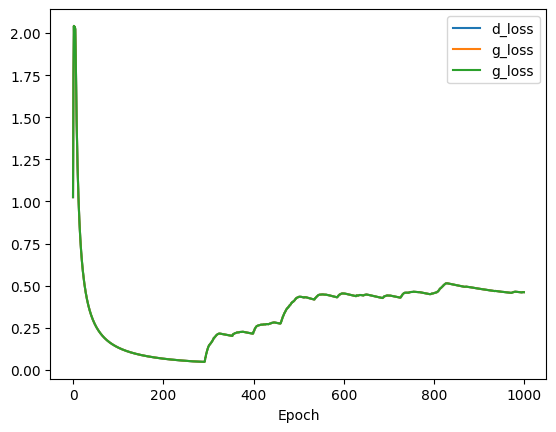

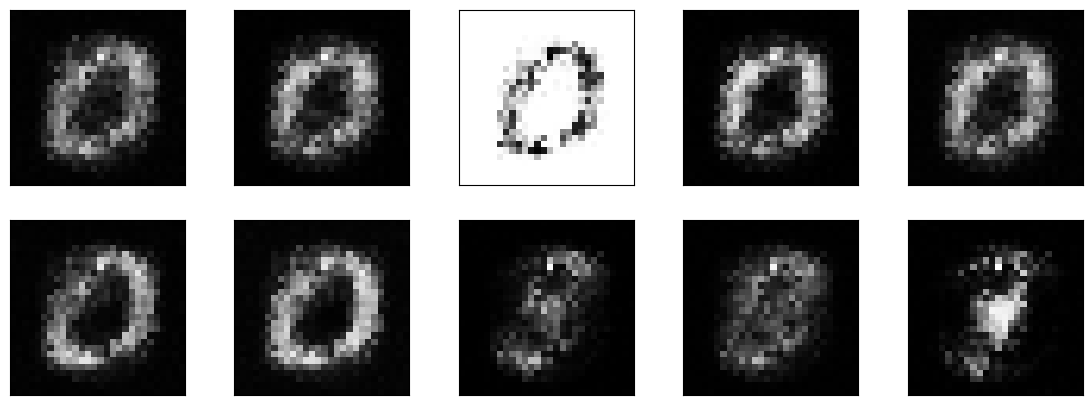

  3%|▎         | 1000/30000 [06:30<5:47:30,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


  3%|▎         | 1001/30000 [06:30<5:05:49,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


  3%|▎         | 1002/30000 [06:30<4:34:16,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


  3%|▎         | 1003/30000 [06:31<4:12:41,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


  3%|▎         | 1004/30000 [06:31<3:57:15,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


  3%|▎         | 1005/30000 [06:32<3:48:10,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


  3%|▎         | 1006/30000 [06:32<3:48:34,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


  3%|▎         | 1007/30000 [06:33<4:11:32,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


  3%|▎         | 1008/30000 [06:33<4:22:29,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


  3%|▎         | 1009/30000 [06:34<4:34:09,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


  3%|▎         | 1010/30000 [06:35<4:42:33,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  3%|▎         | 1011/30000 [06:35<4:52:28,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


  3%|▎         | 1012/30000 [06:36<4:39:05,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


  3%|▎         | 1013/30000 [06:36<4:16:10,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


  3%|▎         | 1014/30000 [06:37<4:00:41,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


  3%|▎         | 1015/30000 [06:37<3:50:50,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


  3%|▎         | 1016/30000 [06:37<3:42:34,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


  3%|▎         | 1017/30000 [06:38<3:39:03,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


  3%|▎         | 1018/30000 [06:38<3:35:12,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


  3%|▎         | 1019/30000 [06:39<3:34:53,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


  3%|▎         | 1020/30000 [06:39<3:33:13,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


  3%|▎         | 1021/30000 [06:40<3:29:16,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


  3%|▎         | 1022/30000 [06:40<3:28:27,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


  3%|▎         | 1023/30000 [06:41<3:33:31,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


  3%|▎         | 1024/30000 [06:41<3:35:43,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


  3%|▎         | 1025/30000 [07:18<91:23:34, 11.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


  3%|▎         | 1026/30000 [07:19<65:55:47,  8.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


  3%|▎         | 1027/30000 [07:19<47:49:27,  5.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


  3%|▎         | 1028/30000 [07:20<34:33:06,  4.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


  3%|▎         | 1029/30000 [07:20<25:14:30,  3.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


  3%|▎         | 1030/30000 [07:21<18:42:35,  2.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


  3%|▎         | 1031/30000 [07:21<14:07:59,  1.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


  3%|▎         | 1032/30000 [07:21<10:55:07,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


  3%|▎         | 1033/30000 [07:22<8:39:06,  1.08s/it] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


  3%|▎         | 1034/30000 [07:22<7:06:45,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


  3%|▎         | 1035/30000 [07:23<6:01:26,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


  3%|▎         | 1036/30000 [07:23<5:16:40,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


  3%|▎         | 1037/30000 [07:24<4:43:46,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


  3%|▎         | 1038/30000 [07:24<4:41:39,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


  3%|▎         | 1039/30000 [07:25<4:53:56,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


  3%|▎         | 1040/30000 [07:26<4:58:28,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


  3%|▎         | 1041/30000 [07:26<5:03:43,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  3%|▎         | 1042/30000 [07:27<5:06:46,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


  3%|▎         | 1043/30000 [07:27<4:39:54,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


  3%|▎         | 1044/30000 [07:28<4:16:16,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


  3%|▎         | 1045/30000 [07:28<4:03:48,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


  3%|▎         | 1046/30000 [07:29<3:52:20,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


  3%|▎         | 1047/30000 [07:29<3:44:00,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


  3%|▎         | 1048/30000 [07:29<3:44:05,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


  3%|▎         | 1049/30000 [07:30<3:38:33,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


  4%|▎         | 1050/30000 [07:30<3:37:48,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


  4%|▎         | 1051/30000 [07:31<3:34:20,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


  4%|▎         | 1052/30000 [07:31<3:29:29,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


  4%|▎         | 1053/30000 [07:32<3:30:28,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


  4%|▎         | 1054/30000 [07:32<3:28:06,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


  4%|▎         | 1055/30000 [07:32<3:29:40,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


  4%|▎         | 1056/30000 [07:33<3:27:36,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


  4%|▎         | 1057/30000 [07:33<3:26:08,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


  4%|▎         | 1058/30000 [07:34<3:28:45,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


  4%|▎         | 1059/30000 [07:34<3:27:50,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


  4%|▎         | 1060/30000 [07:35<3:28:22,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


  4%|▎         | 1061/30000 [07:35<3:26:34,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


  4%|▎         | 1062/30000 [07:35<3:24:57,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


  4%|▎         | 1063/30000 [07:36<3:25:49,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


  4%|▎         | 1064/30000 [07:36<3:24:13,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


  4%|▎         | 1065/30000 [07:37<3:26:07,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


  4%|▎         | 1066/30000 [07:37<3:52:54,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


  4%|▎         | 1067/30000 [07:38<4:12:07,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


  4%|▎         | 1068/30000 [07:39<4:28:16,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|▎         | 1069/30000 [07:39<4:46:23,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


  4%|▎         | 1070/30000 [07:40<4:43:03,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


  4%|▎         | 1071/30000 [07:40<4:19:45,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


  4%|▎         | 1072/30000 [07:41<4:05:15,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


  4%|▎         | 1073/30000 [07:41<3:52:48,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


  4%|▎         | 1074/30000 [07:42<3:43:57,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


  4%|▎         | 1075/30000 [07:42<3:38:39,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


  4%|▎         | 1076/30000 [07:42<3:34:25,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


  4%|▎         | 1077/30000 [07:43<3:33:18,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


  4%|▎         | 1078/30000 [07:43<3:31:32,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


  4%|▎         | 1079/30000 [07:44<3:30:29,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


  4%|▎         | 1080/30000 [07:44<3:29:54,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


  4%|▎         | 1081/30000 [07:45<3:29:52,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


  4%|▎         | 1082/30000 [07:45<3:29:00,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


  4%|▎         | 1083/30000 [07:45<3:27:59,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


  4%|▎         | 1084/30000 [07:46<3:27:51,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


  4%|▎         | 1085/30000 [07:46<3:24:44,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


  4%|▎         | 1086/30000 [07:47<3:25:13,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


  4%|▎         | 1087/30000 [07:47<3:26:49,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


  4%|▎         | 1088/30000 [07:48<3:27:06,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


  4%|▎         | 1089/30000 [07:48<3:27:06,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


  4%|▎         | 1090/30000 [07:48<3:29:34,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


  4%|▎         | 1091/30000 [07:49<3:27:34,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


  4%|▎         | 1092/30000 [07:49<3:28:51,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


  4%|▎         | 1093/30000 [07:50<3:43:02,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


  4%|▎         | 1094/30000 [08:01<29:33:13,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [ ]:
num_epochs  = 10000  *3
plt_frq     = 100
batchsize   = 100
input_shape = 10 # Number of random inputs to generator.
learning_rate  = .05
momgen      = 0.
momdisc     = 0.
clipnorm    = 1.
decay     =   1e-5

generator     = define_generator(ndense=4, nhid=100, act='tanh', input_shape=input_shape)
discriminator = define_discriminator(ndense=2, nhid=100, act='tanh',
  learning_rate=learning_rate*10, mom=momdisc, decay=decay) #, clipnorm=clipnorm)
discriminator.trainable = False
gan           = Sequential(layers=[generator, discriminator])
optimizer = SGD(learning_rate=learning_rate, momentum=momgen, decay=decay, clipnorm=clipnorm)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)

%history = defaultdict(list)
history = {"d_loss":[], "g_loss":[]}
for epoch in tqdm(range(num_epochs)):

    # Generate images.
    noisebatch = np.random.uniform(-1, 1, size=[batchsize,input_shape])
    noisebatch_data = tf.data.Dataset.from_tensor_slices(noisebatch)
    noisebatch_data = noisebatch_data.batch(batch_size=batchsize)
    generated  = generator.predict(noisebatch_data)

    # Update discriminator.
    databatch  = X_train[np.random.randint(0,X_train.shape[0], size=batchsize), :]
    X          = np.concatenate([databatch, generated])
    T          = np.concatenate([np.ones((databatch.shape[0],)), np.zeros((generated.shape[0],))]) # Real:1, fake:0
    discriminator.trainable = True
    d_loss  = discriminator.train_on_batch(X,T)
    history["d_loss"].append(d_loss)

    # Update generator.
    noisebatch = np.random.uniform(-1, 1, size=[batchsize,input_shape])
    T          = np.ones((noisebatch.shape[0],)) # Try to generate data that looks real.
    discriminator.trainable = False
    g_loss = gan.train_on_batch(noisebatch, T)
    history["g_loss"].append(g_loss)

    # Updates plots
    if epoch % plt_frq == plt_frq - 1:
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plot_loss(history)
        plot_gen(generator, input_shape=input_shape)


# Attempt 2: Convolution

In [10]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.core import Flatten
from keras.optimizers import SGD
from keras.datasets import mnist
import numpy as np
#from PIL import Image
import argparse
import math

def generator_model():
    model = Sequential()
    model.add(Dense(input_dim=100, units=1024))
    model.add(Activation('tanh'))
    model.add(Dense(128*7*7))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Reshape((128, 7, 7), input_shape=(128*7*7,)))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Convolution2D(64, 5, 5, border_mode='same'))
    model.add(Activation('tanh'))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Convolution2D(1, 5, 5, border_mode='same'))
    model.add(Activation('tanh'))
    return model


def discriminator_model():
    model = Sequential()
    model.add(Convolution2D(
                        64, 5, 5,
                        border_mode='same',
                        input_shape=(1, 28, 28)))
    model.add(Activation('tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(128, 5, 5))
    model.add(Activation('tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('tanh'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    return model

def generator_containing_discriminator(generator, discriminator):
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False
    model.add(discriminator)
    return model

num_epochs  = 10000
plt_frq     = 500
batchsize   = 100
input_shape = 10 # Number of random inputs to generator.
lr          = .01
momgen      = 0.0
momdisc     = 0.0
clipnorm    = 1.
decay     =   1e-5

discriminator_on_generator = generator_containing_discriminator(generator, discriminator)
d_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
g_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
generator.compile(loss='binary_crossentropy', optimizer="SGD")
discriminator_on_generator.compile(loss='binary_crossentropy', optimizer=g_optim)
discriminator.trainable = True
discriminator.compile(loss='binary_crossentropy', optimizer=d_optim)

history = defaultdict(list)
for epoch in tqdm(range(num_epochs)):

    # Generate images.
    noisebatch = np.random.uniform(-1, 1, size=[batchsize,input_shape])
    generated  = generator.predict(noisebatch)

    # Update discriminator.
    databatch  = X_train[np.random.randint(0,X_train.shape[0], size=batchsize), :]
    X          = np.concatenate([databatch, generated])
    T          = np.concatenate([np.ones((databatch.shape[0],)), np.zeros((generated.shape[0],))]) # Real:1, fake:0
    discriminator.trainable = True
    d_loss  = discriminator.train_on_batch(X,T)
    history["d_loss"].append(d_loss)

    # Update generator.
    noisebatch = np.random.uniform(-1, 1, size=[batchsize,input_shape])
    T          = np.ones((noisebatch.shape[0],)) # Try to generate data that looks real.
    discriminator.trainable = False
    g_loss = gan.train_on_batch(noisebatch, T)
    history["g_loss"].append(g_loss)

    # Updates plots
    if epoch % plt_frq == plt_frq - 1:
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plot_loss(history)
        plot_gen(generator, input_shape=input_shape)

ModuleNotFoundError: No module named 'keras.layers.core'